# Urban area mapping using Sentinel 1 data

* **Products used:** 
[s1_rtc](https://explorer.digitalearth.africa/products/s1_rtc), 

> **_NOTE:_** Please run this notebook using the the Large Environment with 4 cores and 32 GB Memory.

## Background

Urban areas account for a small proportion of global land cover, but support daily human life and exert a great influence on environmental and ecological changes [Xia et al. 2019](https://doi.org/10.3390/rs11121470). 
This means that constant monitoring of the built environment is crucial for sustainable development. 
There are different techniques used to classify urban areas using both optical and radar data, one of the simplest is Kmeans clustering (unsupervised machine learning). 

While urban areas can be mapped using optical data, the image quality is strongly affected by weather conditions such as cloud cover. 
This limits the temporal avaliability of clear images in tropical areas that experience very cloudy weather and heavy rains. 
The image quality of radar data is independent of daylight and weather conditions, which makes it more suitable for urban area mapping. 
For more information, see the [Sentinel-1](../Datasets/Sentinel_1.ipynb) notebook.

## Description

This notebook uses Kmeans Clustering to classify land as 'urban' then compares those results with the ESA WorldCover global land cover product for the year 2020.

The choice of the number of clusters to use for the Kmeans Clustering and the pixel value that represents the urban land cover class can be informed by comparing the prediction images with the "ground truth" dataset.

This notebook contains the following steps:

1. Select a location and time range  for the analysis.
2. Load Sentinel-1 backscatter data for the area of interest. 
3. Convert the digital numbers to dB values for analysis.
4. Generate a median VH and VV polarization composite image from the Sentinel 1 data.
5. Perform Kmeans Clustering on the median composite image. 
6. Show the Kmeans Clustering urbanization prediction image.
7. Load and show the "ground truth" ESA Worldcover data for the year 2020.
8. Compare the urbanization prediction with the "ground truth" data visually and statistically.

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import the Python packages that are used for the analysis.

In [1]:
# Uncomment the line below to install the tabulate module.
# !pip install tabulate

In [2]:
# Load the necessary Python packages.

%matplotlib inline

import warnings
import datacube
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolours
from matplotlib.patches import Patch
from tabulate import tabulate

warnings.filterwarnings("ignore")

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    cohen_kappa_score,
)

from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import display_map, plot_lulc
from deafrica_tools.classification import sklearn_flatten, sklearn_unflatten

### Connect to the datacube

Connect to the datacube so we can access the Digital Earth Africa data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [3]:
dc = datacube.Datacube(app="Urban_area_mapping")

### Analysis parameters

The following cell sets the parameters, which define the area of interest and the length of time to conduct the analysis.
The parameters are:
* `central_lat`: The central latitude of the area of interest to analyse.
* `central_lon`: The central longitude of the area of interest to analyse.
* `buffer`: The number of square degrees to load around the central latitude and longitude. 
For reasonable loading times, set this as `0.1` or lower.
* `time_range`: The time range for your analysis, e.g.`('2020')` if you wanted data from all of the year 2020.

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The example covers part of  Nairobi County, Kenya.

In [4]:
# Define the area of interest.
central_lat = -1.2933
central_lon = 36.8679

lat_buffer = 0.1
lon_buffer = 0.1

# Combine lat, lon with their respective buffers to get area of interest.
lat_range = (central_lat - lat_buffer, central_lat + lat_buffer)
lon_range = (central_lon - lon_buffer, central_lon + lon_buffer)

# Time frame for the analysis.
time_range = "2020"

### View the selected location

The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [5]:
# View the study area
display_map(x=lon_range, y=lat_range)

## Load and view the Sentinel-1 data

### Create a datacube query object
We will create a dictionary that will contain the parameters that will be used to load the Sentinel 1 data from the Digital Earth Africa datacube.

In [6]:
query = {
    "y": lat_range,
    "x": lon_range,
    "time": time_range,
    "output_crs": "EPSG:6933",
    "resolution": (-10, 10),
}

query

{'y': (-1.3933, -1.1932999999999998),
 'x': (36.7679, 36.9679),
 'time': '2020',
 'output_crs': 'EPSG:6933',
 'resolution': (-10, 10)}

### Load the Sentinel 1 data
The first step in the analysis is to load Sentinel-1 backscatter data for the specified area of interest.
This uses the pre-defined [load_ard](../Frequently_used_code/Using_load_ard.ipynb) utility function. 
The `load_ard` function is used here to load an analysis ready dataset free of shadow, and missing data.

In [7]:
ds = load_ard(
    dc=dc, products=["s1_rtc"], measurements=["vv", "vh"], group_by="solar_day", **query
)

Using pixel quality parameters for Sentinel 1
Finding datasets
    s1_rtc
Applying pixel quality/cloud mask
Loading 89 time steps


**Once the load is complete**, examine the data by printing it in the next cell. 
The `Dimensions` attribute reveals the number of time steps in the data set, as well as the number of pixels in the `longitude` and `latitude` dimensions.

In [8]:
print(ds)

<xarray.Dataset>
Dimensions:      (time: 89, y: 2551, x: 1931)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-04T15:56:20.113636 ... 2020-12...
  * y            (y) float64 -1.522e+05 -1.522e+05 ... -1.777e+05 -1.777e+05
  * x            (x) float64 3.548e+06 3.548e+06 ... 3.567e+06 3.567e+06
    spatial_ref  int32 6933
Data variables:
    vv           (time, y, x) float32 0.3886 0.3886 0.09932 ... 0.06189 0.03677
    vh           (time, y, x) float32 0.1015 0.1015 0.05205 ... 0.01837 0.01097
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


### View the Sentinel 1 data

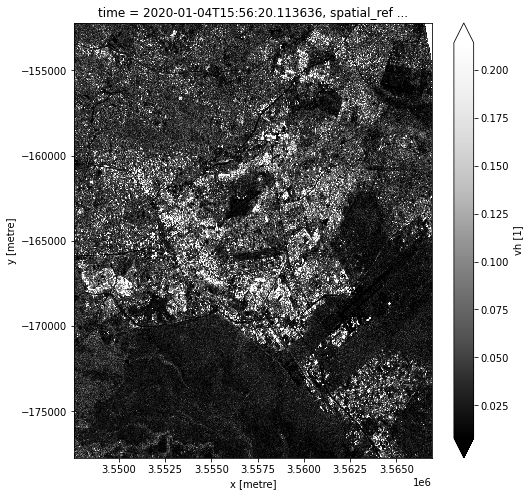

In [9]:
# Plot the first VH observation for the year 2020.
ds.vh.isel(time=0).plot(cmap="Greys_r", robust=True, figsize=(8, 8))

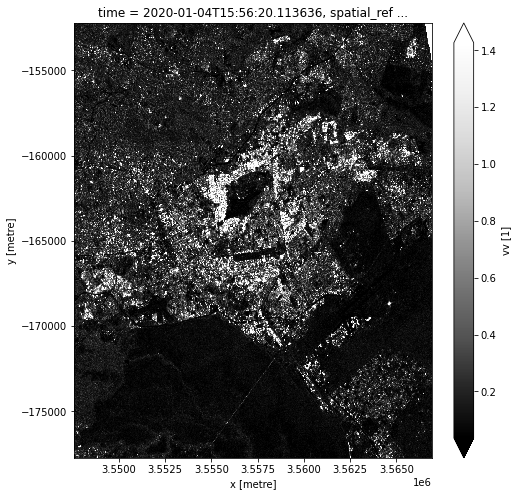

In [10]:
# Plot the first VV observation for the year 2020.
ds.vv.isel(time=0).plot(cmap="Greys_r", robust=True, figsize=(8, 8))

## Convert the Digital Number (DN) values to Decibel values (dB)

The Sentinel-1 backscatter data is provided as digital number (DN), which can be converted to backscatter in decibel unit (dB) using the function:

\begin{equation}
10 * \log_{10}(\text{DN})
\end{equation}


It is often useful to convert the backscatter to decible (dB) for analysis because the backscatter in dB unit has a more symmetric noise profile and less skewed value distribution for easier statistical evaluation.

In [11]:
# Convert DN to db values.
ds["vv_db"] = 10 * xr.ufuncs.log10(ds.vv)
ds["vh_db"] = 10 * xr.ufuncs.log10(ds.vh)

## Generate a median value composite image
We will combine all the VH and VV observations in our Sentinel 1 `ds` `xarray.Dataset` into a single, complete (or near complete) image representing the median of the time period.

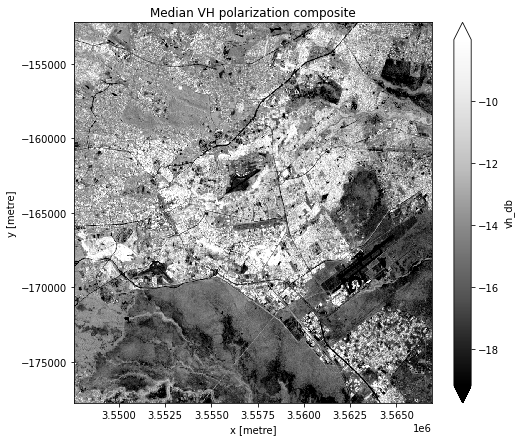

In [12]:
# Obtain the median of all VH observations for the time period.
median_vh = ds.vh_db.median(dim="time")

# Plot the median VH polarization composite.
fig = plt.figure(figsize=(8, 7))
median_vh.plot(cmap="Greys_r", robust=True)
plt.title("Median VH polarization composite");

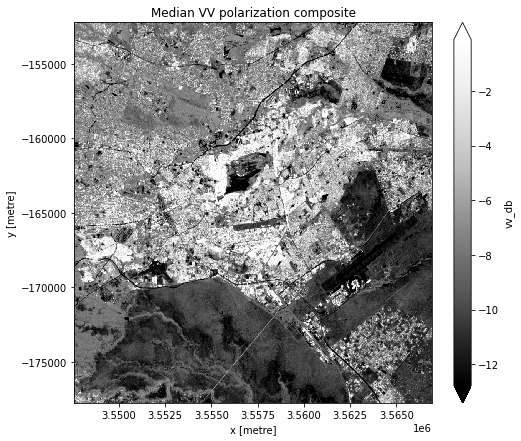

In [13]:
# Obtain the median of all VV observations for the time period.
median_vv = ds.vv_db.median(dim="time")

# Plot the median VV polarization composite.
fig = plt.figure(figsize=(8, 7))
median_vv.plot(cmap="Greys_r", robust=True)
plt.title("Median VV polarization composite");

Merge the median VH and VV polarization composites into one dataset. 

In [14]:
# Merge the median VH and VV polarization composite Data Arrays into one dataset.
img = xr.merge([median_vh.rename("median_vh"), median_vv.rename("median_vv")])

print(img)

<xarray.Dataset>
Dimensions:      (y: 2551, x: 1931)
Coordinates:
  * y            (y) float64 -1.522e+05 -1.522e+05 ... -1.777e+05 -1.777e+05
  * x            (x) float64 3.548e+06 3.548e+06 ... 3.567e+06 3.567e+06
    spatial_ref  int32 6933
Data variables:
    median_vh    (y, x) float32 -11.1 -11.1 -12.8 -12.8 ... -17.41 -17.41 -17.79
    median_vv    (y, x) float32 -3.632 -3.632 -5.781 ... -10.98 -10.98 -11.61


## Classification using Kmeans Clustering

In the next cell we will create a set of functions which will together be used to perform Kmeans Clustering on our median value composite image. 
This functions are adapted from the ones used [here](https://ml-gis-service.com/index.php/2020/10/14/data-science-unsupervised-classification-of-satellite-images-with-k-means-algorithm/).

In [15]:
# Defining functions to use for the Kmeans clustering.


def show_clustered(predicted_ds):
    """
    Takes the predicted xarray dataset and plots it using the
    clustering_predicted band.

    Last modified: November 2021
    Parameters
    ----------
    predicted_ds : xarray Dataset
    The xarray dataset which is the result of the kmeans clustering.

    Returns
    -------
    An plot of the classification band of the predicted_ds.
    """

    # Display predicted_ds Dataset with upto 6 unique classes.
    image = predicted_ds.clustering_predicted

    # Color list with 6 colors from the virdis color map.
    no_classes = len(np.unique(image))
    colour_list = ["#fde725", "#440154", "#22a884", "#414487", "#2a788e", "#7ad151"]
    colours = colour_list[:no_classes]
    cmap = mcolours.ListedColormap(colours)
    bounds = range(0, no_classes + 1)
    norm = mcolours.BoundaryNorm(np.array(bounds), cmap.N)
    cblabels = [str(i) for i in bounds]
    im = image.plot.imshow(cmap=cmap, norm=norm, add_colorbar=True, figsize=(15, 15))
    cb = im.colorbar
    cb.set_ticks(np.arange(0, no_classes + 1, 1) + 0.5)
    cb.set_ticklabels(cblabels)
    plt.axis("off")
    title = f"Kmeans Clustering Predicted Image using {no_classes} clusters"
    plt.title(title)
    plt.show()


def kmeans_clustering(input_xr, cluster_range):
    """
    Perform sklearn Kmeans clustering on the input Dataset
    or Data Array.

    Last modified: November 2021

    Parameters
    ----------
    input_xr : xarray.DataArray or xarray.Dataset
        Must have dimensions 'x' and 'y', may have dimension 'time'.

    cluster_range : list
        A list of the number of clusters to use to perform the Kmeans clustering
        on the input_xr Dataset.

    Returns
    ----------
    results : dictionary
        A dictionary with the number of clusters as keys and the predicted datasets as
        the values. Each predicted dataset is an xarray.Dataset with the same dimensions
        'x', 'y' and 'time' as the input_xr.

    """

    # Use the sklearn_flatten function to convert the Dataset into a 2 dimensional numpy array.
    model_input = sklearn_flatten(input_xr)

    # Standardize the data.
    scaler = StandardScaler()
    model_input = scaler.fit_transform(model_input)

    # Dictionary to save results
    results = {}

    # Perform Kmeans clustering on the input dataset for each number of clusters
    # in the cluster_range list.
    for no_of_clusters in cluster_range:
        # Set up the kmeans classification by specifying the number of clusters
        # with initialization as k-means++.
        km = KMeans(n_clusters=no_of_clusters, init="k-means++")

        # Begin iteratively computing the position of the clusters.
        km.fit(model_input)

        # Use the sklearn kmeans .predict method to assign all the pixels of the
        # model input to a unique cluster.
        flat_predictions = km.predict(model_input)

        # Use the sklearn_unflatten function to convert the flat predictions into a
        # xarray Dataset.
        predicted = sklearn_unflatten(flat_predictions, input_xr)

        # Rename the band of the predicted xarray Dataset from band to classified.
        predicted = predicted.rename({"band": "clustering_predicted"})

        # Append the results to a dictionary using the number of clusters as the
        # column as an key.
        results.update({str(no_of_clusters): predicted})

    return results

In the next cell, we will use a range of clusters to perform  K-means classification on our median composite dataset.

In [16]:
cluster_range = [2, 3, 4]
results = kmeans_clustering(img, cluster_range)
results

{'2': <xarray.Dataset>
 Dimensions:               (y: 2551, x: 1931)
 Coordinates:
   * y                     (y) float64 -1.522e+05 -1.522e+05 ... -1.777e+05
   * x                     (x) float64 3.548e+06 3.548e+06 ... 3.567e+06
     spatial_ref           int32 6933
 Data variables:
     clustering_predicted  (y, x) int32 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1
 Attributes:
     grid_mapping:  spatial_ref,
 '3': <xarray.Dataset>
 Dimensions:               (y: 2551, x: 1931)
 Coordinates:
   * y                     (y) float64 -1.522e+05 -1.522e+05 ... -1.777e+05
   * x                     (x) float64 3.548e+06 3.548e+06 ... 3.567e+06
     spatial_ref           int32 6933
 Data variables:
     clustering_predicted  (y, x) int32 1 1 2 2 2 2 1 1 1 2 ... 0 0 0 0 0 0 0 0 0
 Attributes:
     grid_mapping:  spatial_ref,
 '4': <xarray.Dataset>
 Dimensions:               (y: 2551, x: 1931)
 Coordinates:
   * y                     (y) float64 -1.522e+05 -1.522e+05 ... -1.777e+05
   * x     

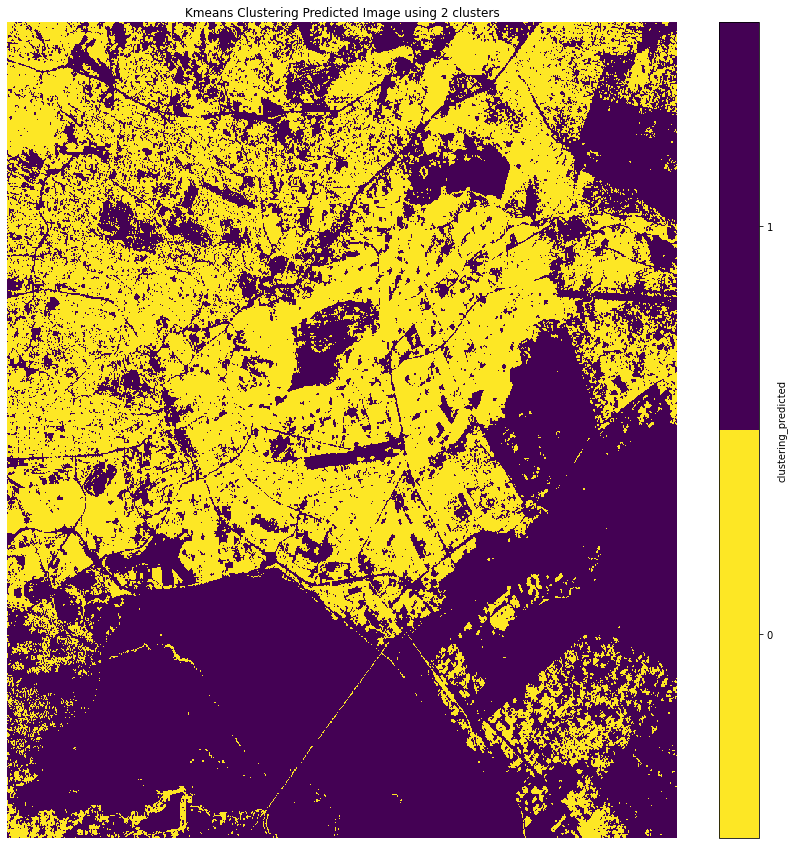

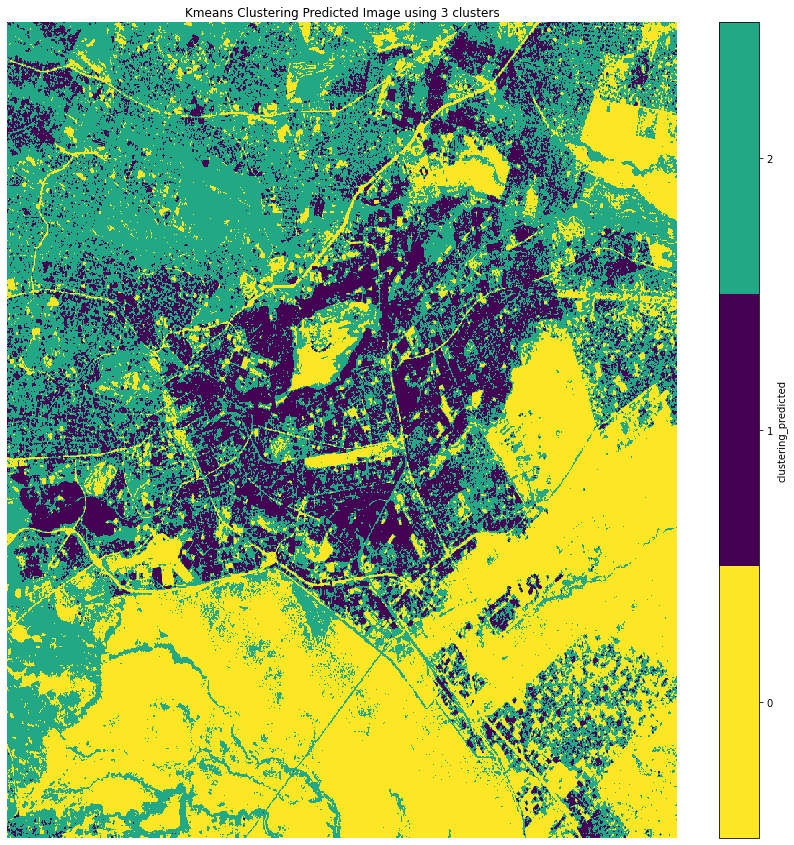

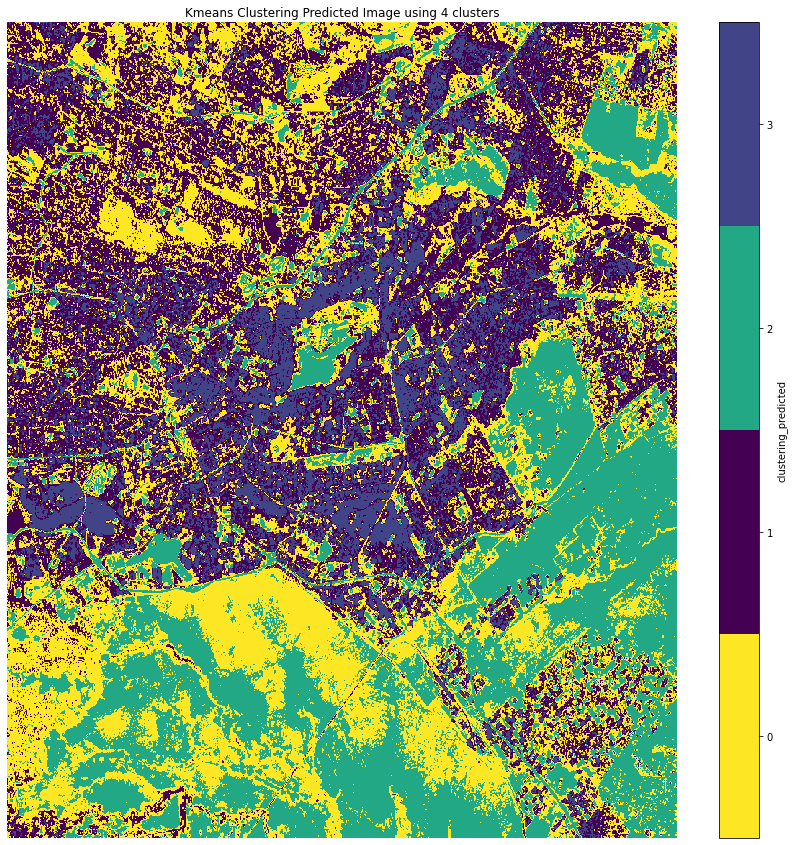

In [17]:
# Plot each of the predicted images.
for predicted_ds in results.values():
    show_clustered(predicted_ds)

From the plotted predicted images above the best number of clusters to use is `3` clusters. 
In this image, the most likely pixel value to represent the urban/buit up land cover class is the pixel value `1`. 

In [18]:
# Mask the dataset to retain the pixels which are most likely to be urban/built up.
key = "3"
pixel_value = 1
clustering_predicted_ds = results[key] == pixel_value
print(clustering_predicted_ds)

<xarray.Dataset>
Dimensions:               (y: 2551, x: 1931)
Coordinates:
  * y                     (y) float64 -1.522e+05 -1.522e+05 ... -1.777e+05
  * x                     (x) float64 3.548e+06 3.548e+06 ... 3.567e+06
    spatial_ref           int32 6933
Data variables:
    clustering_predicted  (y, x) bool True True False ... False False False
Attributes:
    grid_mapping:  spatial_ref


In [19]:
# Replace the values True and False with 1 and 0 respectively.
repl_dict = {True: 1, False: 0}

input_array = clustering_predicted_ds["clustering_predicted"].values

out = np.zeros(input_array.shape, dtype=np.int16)

for key in repl_dict:
    out[input_array == key] = repl_dict[key]

clustering_predicted_ds["clustering_predicted"].values = out

print(clustering_predicted_ds)

<xarray.Dataset>
Dimensions:               (y: 2551, x: 1931)
Coordinates:
  * y                     (y) float64 -1.522e+05 -1.522e+05 ... -1.777e+05
  * x                     (x) float64 3.548e+06 3.548e+06 ... 3.567e+06
    spatial_ref           int32 6933
Data variables:
    clustering_predicted  (y, x) int16 1 1 0 0 0 0 1 1 1 0 ... 0 0 0 0 0 0 0 0 0
Attributes:
    grid_mapping:  spatial_ref


In the `clustering_predicted_ds` xarray Dataset the pixel value `1` is urban land cover and for non-urban land cover it is `0`. 

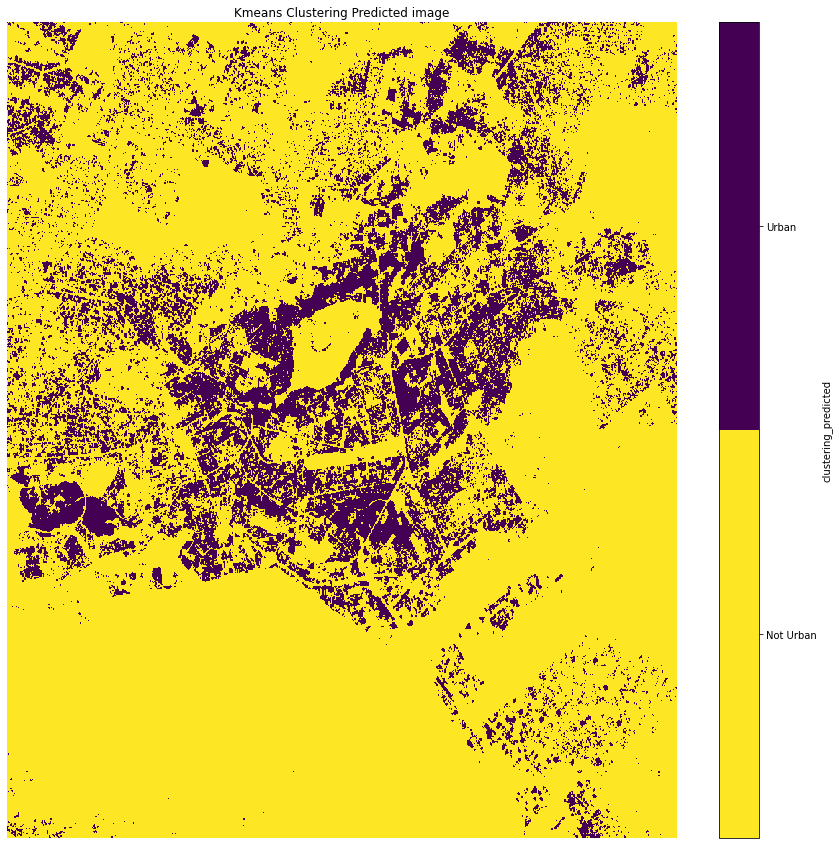

In [20]:
# Plot the clustering_predicted_ds Dataset.
image = clustering_predicted_ds.clustering_predicted
no_classes = 2
colour_list = ["#fde725", "#440154"]
cmap = mcolours.ListedColormap(colour_list)
bounds = range(0, no_classes + 1)
norm = mcolours.BoundaryNorm(np.array(bounds), cmap.N)
cblabels = ["Not Urban", "Urban"]
im = image.plot.imshow(cmap=cmap, norm=norm, add_colorbar=True, figsize=(15, 15))
cb = im.colorbar
cb.set_ticks(np.arange(0, no_classes + 1, 1) + 0.5)
cb.set_ticklabels(cblabels)
plt.axis("off")
plt.title("Kmeans Clustering Predicted image")
plt.show()

## Validation of the Kmeans Clustering classification
We will compare the performance of the urban area Kmeans clustering classification result against a built area (urban area) map for the study area derived from the ESA World Cover, global 10 m land use/land cover data from 2020. 

### Obtain the validation dataset

In [21]:
# Load the ESA land use land cover product over the same region as the Sentinel 1 dataset.
ds_esa = dc.load(product="esa_worldcover", like=ds.geobox).squeeze()

print(ds_esa)

<xarray.Dataset>
Dimensions:         (y: 2551, x: 1931)
Coordinates:
    time            datetime64[ns] 2020-07-01T12:00:00
  * y               (y) float64 -1.522e+05 -1.522e+05 ... -1.777e+05 -1.777e+05
  * x               (x) float64 3.548e+06 3.548e+06 ... 3.567e+06 3.567e+06
    spatial_ref     int32 6933
Data variables:
    classification  (y, x) uint8 10 10 10 20 10 10 60 ... 30 30 30 30 30 30 30
Attributes:
    crs:           PROJCS["WGS 84 / NSIDC EASE-Grid 2.0 Global",GEOGCS["WGS 8...
    grid_mapping:  spatial_ref


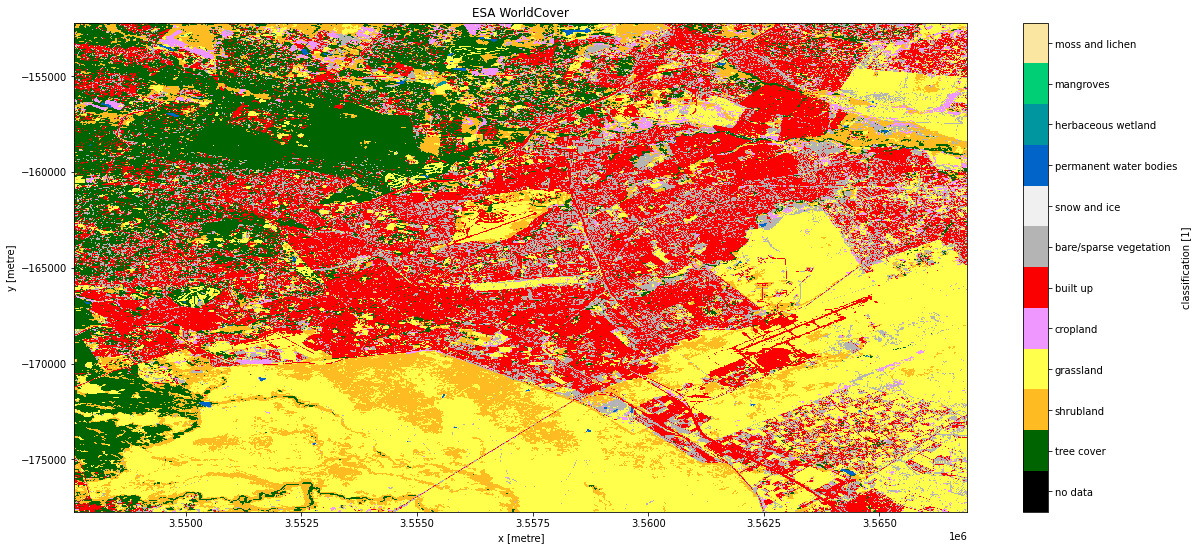

In [22]:
# Plot the ESA land use land cover product.
fig, ax = plt.subplots(figsize=(20, 9), sharey=True)
plot_lulc(ds_esa["classification"], product="ESA", legend=True, ax=ax)
plt.title("ESA WorldCover");

In [23]:
# Get the pixel value for each land cover class represented in the esa dataset.
dc_measurements = dc.list_measurements()
esa_lulc_measurements = dc_measurements.loc[["esa_worldcover"]]
esa_lulc_measurements.loc["esa_worldcover", "classification"].flags_definition

{'data': {'bits': [0, 1, 2, 3, 4, 5, 6, 7],
  'values': {'0': 'no data',
   '10': 'tree cover',
   '20': 'shrubland',
   '30': 'grassland',
   '40': 'cropland',
   '50': 'built up',
   '60': 'bare/sparse vegetation',
   '70': 'snow and ice',
   '80': 'permanent water bodies',
   '90': 'herbaceous wetland',
   '95': 'mangroves',
   '100': 'moss and lichen'},
  'description': 'Land Use/Land Cover class'}}

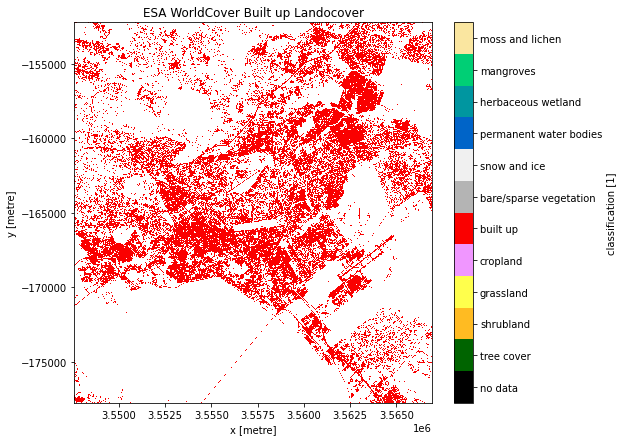

In [24]:
# Plot the built up land cover from the ESA worldcover dataset.
built_up = ds_esa.where(ds_esa["classification"] == 50)
plot_lulc(built_up["classification"], product="ESA", legend=True, figsize=(8, 7))
plt.title("ESA WorldCover Built up Landocover");

In [25]:
# Pixels with a value of 50 are classified as built up land cover.
# Mask the ESA land cover dataset to retain only pixels with the value 50.
actual = ds_esa["classification"] == 50

# Replace the values True and False with 1 and 0 respectively.
repl_dict = {True: 1, False: 0}

input_array = actual.values

out = np.zeros(input_array.shape, dtype=np.int16)

for key in repl_dict:
    out[input_array == key] = repl_dict[key]

actual.values = out

print(actual)

<xarray.DataArray 'classification' (y: 2551, x: 1931)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)
Coordinates:
    time         datetime64[ns] 2020-07-01T12:00:00
  * y            (y) float64 -1.522e+05 -1.522e+05 ... -1.777e+05 -1.777e+05
  * x            (x) float64 3.548e+06 3.548e+06 ... 3.567e+06 3.567e+06
    spatial_ref  int32 6933


### Accuracy assessment metrics
We will use functions from the `sklearn.metrics` module to evaluate the Kmeans clustering classification. 
Accuracy is used when the True Positives and True negatives are more important while F1-score is used when the False Negatives and False Positives are crucial. 

$$
\begin{aligned}
\text{Overall Accuracy (OA)} = \frac{\text{True Positive} + \text{True Negative}}{\text{Total Pixels}}
\end{aligned}
$$

$$
\begin{aligned}
\text{Producer's Accuracy (PA) or Precision} = \frac{\text{True Positive}}{\text{True Positive} + \text{False Positive}}
\end{aligned}
$$

$$
\begin{aligned}
\text{User's accuracy (UA) or  Recall} = \frac{\text{True Positive}}{\text{True Positive} + \text{False Negative}}
\end{aligned}
$$

$$
\begin{aligned}
\text{F1 Score} = 2*\frac{\text{Recall}*\text{Precision}}{\text{Recall} + \text{Precision}}
\end{aligned}
$$

$$
\begin{aligned}
\text{Kappa  } \kappa = (p_o - p_e) / (1 - p_e)
\end{aligned}
$$

In [26]:
# Metrics for the Kmeans Clustering.

y_true = sklearn_flatten(actual)
y_pred_kmeans = sklearn_flatten(clustering_predicted_ds)

# Producer's Accuracies.
precision_kmeans = precision_score(y_true, y_pred_kmeans, labels=[0, 1], average=None)
urban_precision_kmeans = precision_kmeans[1] * 100
non_urban_precision_kmeans = precision_kmeans[0] * 100

# User's Accuracies.
recall_kmeans = recall_score(y_true, y_pred_kmeans, labels=[0, 1], average=None)
urban_recall_kmeans = recall_kmeans[1] * 100
non_urban_recall_kmeans = recall_kmeans[0] * 100

# Overall Accuracy.
accuracy_kmeans = accuracy_score(y_true, y_pred_kmeans, normalize=True)
overall_accuracy_kmeans = accuracy_kmeans * 100

# Micro-averaged F1 score.
f1score_kmeans = f1_score(y_true, y_pred_kmeans, average="micro") * 100

# Kappa coefficient.
kappa_kmeans = cohen_kappa_score(y_true, y_pred_kmeans)

print(
    "\033[1m" + "\033[91m" + "Urban Area Mapping using Kmeans Clustering Results"
)  # bold print and red
print("\033[0m")  # stop bold and red
print("Overall Accuracy: \t\t", round(overall_accuracy_kmeans, 3))
print("Micro-averaged F1 score: \t", round(f1score_kmeans, 3))
print("Kappa coefficient: \t\t", round(kappa_kmeans, 3))
print("")
table1 = [
    (
        "Producer's Accuracy",
        round(urban_precision_kmeans, 3),
        round(non_urban_precision_kmeans, 3),
    ),
    (
        "User's Accuracy",
        round(urban_recall_kmeans, 3),
        round(non_urban_recall_kmeans, 3),
    ),
]
print(tabulate(table1, stralign="left", headers=("", "Urban", "Non-urban")))

Urban Area Mapping using Kmeans Clustering Results

Overall Accuracy: 		 79.972
Micro-averaged F1 score: 	 79.972
Kappa coefficient: 		 0.439

                       Urban    Non-urban
-------------------  -------  -----------
Producer's Accuracy   66.615       83.225
User's Accuracy       49.174       91.097


The `dstack` calls provide the `imshow` calls with RGB array inputs. 
For the plotted image, the first channel (red) is the actual (ground truth, ESA Worldcover) values, and both the second and third channels (green, blue) are the predicted values (green + blue = cyan).

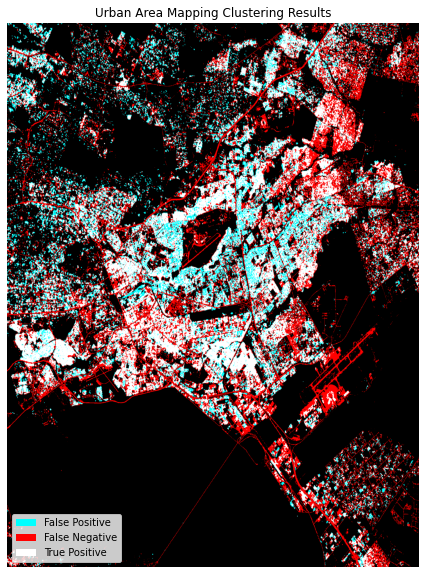

In [27]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(
    np.dstack(
        (
            actual.data.astype(float),
            clustering_predicted_ds.clustering_predicted.data.astype(float),
            clustering_predicted_ds.clustering_predicted.data.astype(float),
        )
    )
)
plt.legend(
    [Patch(facecolor="cyan"), Patch(facecolor="red"), Patch(facecolor="white")],
    ["False Positive", "False Negative", "True Positive"],
    loc="lower left",
    fontsize=10,
)
plt.axis("off")
plt.title("Urban Area Mapping Clustering Results");

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [28]:
print(datacube.__version__)

1.8.6


**Last Tested:**

In [29]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2021-11-26'